Investigate the influence of different training parameters such as batch size and learning rate.
Perform a  random search to find the optimal training
parameters.

RNN model

In [1]:
import mido
import numpy as np
import matplotlib.pyplot as plt
import PreProcessor as pp
import gc
from keras.models import Model
from tensorflow.keras.layers import Input, SimpleRNN, LSTM, GRU, Dense, Lambda, Softmax, Activation, concatenate
from keras import optimizers
import tensorflow as tf
from keras_tuner import RandomSearch
import utils as ut



In [2]:
# Définir le modèle
#Loss plot w.r.t. the learning rate
dataset = pp.load_dataset(r"C:\Users\anhly\Desktop\DD2424-MusicGen1/adl-piano-midi")
ClassicSongs = pp.files_to_songs(dataset["Classical"])
#RockSongs = pp.files_to_songs(dataset["Rock"])
#Children=pp.files_to_songs(dataset["Children"])
#Ambient=pp.files_to_songs(dataset["Ambient"])
#Blues=pp.files_to_songs(dataset["Blues"])
#Country=pp.files_to_songs(dataset["Country"])
#Electronic=pp.files_to_songs(dataset["Electronic"])
#Folk=pp.files_to_songs(dataset["Folk"])
#Jazz=pp.files_to_songs(dataset["Jazz"])
#Latin=pp.files_to_songs(dataset["Latin"])
#Pop=pp.files_to_songs(dataset["Pop"])
#Rap=pp.files_to_songs(dataset["Rap"])
channel_to_ind, ind_to_channel, note_to_ind, ind_to_note, velocity_to_ind, ind_to_velocity = pp.dicts_from_songs(ClassicSongs)
time_range = pp.ranges_from_songs(ClassicSongs)

n_Channels = len(channel_to_ind)
n_Notes = len(note_to_ind)
n_Velocities = len(velocity_to_ind)


dim = 250
#RNN_model = ut.create_model("RNN",dim,n_Channels,n_Notes,n_Velocities,time_range)

In [3]:
print(velocity_to_ind)

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6, 7: 7, 8: 8, 9: 9, 10: 10, 11: 11, 12: 12, 13: 13, 14: 14, 15: 15, 16: 16, 17: 17, 18: 18, 19: 19, 20: 20, 21: 21, 22: 22, 23: 23, 24: 24, 25: 25, 26: 26, 27: 27, 28: 28, 29: 29, 30: 30, 31: 31, 32: 32, 33: 33, 34: 34, 35: 35, 36: 36, 37: 37, 38: 38, 39: 39, 40: 40, 41: 41, 42: 42, 43: 43, 44: 44, 45: 45, 46: 46, 47: 47, 48: 48, 49: 49, 50: 50, 51: 51, 52: 52, 53: 53, 54: 54, 55: 55, 56: 56, 57: 57, 58: 58, 59: 59, 60: 60, 61: 61, 62: 62, 63: 63, 64: 64, 65: 65, 66: 66, 67: 67, 68: 68, 69: 69, 70: 70, 71: 71, 72: 72, 73: 73, 74: 74, 75: 75, 76: 76, 77: 77, 78: 78, 79: 79, 80: 80, 81: 81, 82: 82, 83: 83, 84: 84, 85: 85, 86: 86, 87: 87, 88: 88, 89: 89, 90: 90, 91: 91, 92: 92, 93: 93, 94: 94, 95: 95, 96: 96, 97: 97, 98: 98, 99: 99, 100: 100, 101: 101, 102: 102, 103: 103, 104: 104, 105: 105, 106: 106, 107: 107, 108: 108, 109: 109, 110: 110, 111: 111, 112: 112, 113: 113, 114: 114, 115: 115, 116: 116, 117: 117, 118: 118, 119: 119, 120: 120, 121: 121,

In [4]:

def prep_data(seq_length,ClassicSongs,n_Channels,n_Notes,n_Velocities,channel_to_ind,note_to_ind,velocity_to_ind,val_split=0.1,test_split=0.1):


    total_samples = sum((len(song) - 1) // seq_length for song in ClassicSongs.values())

    X_Channels = np.zeros((total_samples, seq_length, n_Channels))
    X_Notes = np.zeros((total_samples, seq_length, n_Notes))
    X_Velocities = np.zeros((total_samples, seq_length, n_Velocities))
    X_Times = np.zeros((total_samples, seq_length, 1))
    y_Channels = np.zeros((total_samples, seq_length, n_Channels))
    y_Notes = np.zeros((total_samples, seq_length, n_Notes))
    y_Velocities = np.zeros((total_samples, seq_length, n_Velocities))
    y_Times = np.zeros((total_samples, seq_length, 1))

    current_index = 0
    for song in ClassicSongs.values():
        song_x_channels, song_y_channels = pp.label_sequences(pp.one_hot_encode(channel_to_ind, song[:, 0]), seq_length)
        song_x_notes, song_y_notes = pp.label_sequences(pp.one_hot_encode(note_to_ind, song[:, 1]), seq_length)
        song_x_velocities, song_y_velocities = pp.label_sequences(pp.one_hot_encode(velocity_to_ind, song[:, 2]), seq_length)
        song_x_ticks, song_y_ticks = pp.label_sequences(song[:, 3:], seq_length)
        
        n_samples = song_x_channels.shape[0]
        next_index = current_index + n_samples
        
        X_Channels[current_index:next_index] = song_x_channels
        X_Notes[current_index:next_index] = song_x_notes
        X_Velocities[current_index:next_index] = song_x_velocities
        X_Times[current_index:next_index] = song_x_ticks
        y_Channels[current_index:next_index] = song_y_channels
        y_Notes[current_index:next_index] = song_y_notes
        y_Velocities[current_index:next_index] = song_y_velocities
        y_Times[current_index:next_index] = song_y_ticks
        
        current_index = next_index

    n_val = int(total_samples*val_split)
    n_test = int(total_samples*test_split)
    indices = np.random.permutation(total_samples)
    val_indices = indices[:n_val]
    test_indices = indices[-n_test:]
    train_indices = indices[n_val:-n_test]

    Test_X_Channels = X_Channels[test_indices,:,:]
    Test_X_Notes = X_Notes[test_indices,:,:]
    Test_X_Velocities = X_Velocities[test_indices,:,:]
    Test_X_Times = X_Times[test_indices,:,:]
    Test_y_Channels = y_Channels[test_indices,:,:]
    Test_y_Notes = y_Notes[test_indices,:,:]
    Test_y_Velocities = y_Velocities[test_indices,:,:]
    Test_y_Times = y_Times[test_indices,:,:]

    Val_X_Channels = X_Channels[val_indices,:,:]
    Val_X_Notes = X_Notes[val_indices,:,:]
    Val_X_Velocities = X_Velocities[val_indices,:,:]
    Val_X_Times = X_Times[val_indices,:,:]
    Val_y_Channels = y_Channels[val_indices,:,:]
    Val_y_Notes = y_Notes[val_indices,:,:]
    Val_y_Velocities = y_Velocities[val_indices,:,:]
    Val_y_Times = y_Times[val_indices,:,:]

    X_Channels = X_Channels[train_indices,:,:]
    X_Notes = X_Notes[train_indices,:,:]
    X_Velocities = X_Velocities[train_indices,:,:]
    X_Times = X_Times[train_indices,:,:]
    y_Channels = y_Channels[train_indices,:,:]
    y_Notes = y_Notes[train_indices,:,:]
    y_Velocities = y_Velocities[train_indices,:,:]
    y_Times = y_Times[train_indices,:,:]

    return X_Channels, X_Notes, X_Velocities, X_Times, y_Channels, y_Notes, y_Velocities, y_Times, Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times, Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times, Test_X_Channels, Test_X_Notes, Test_X_Velocities, Test_X_Times, Test_y_Channels, Test_y_Notes, Test_y_Velocities, Test_y_Times


In [5]:
seq_length=30
X_Channels, X_Notes, X_Velocities, X_Times, y_Channels, y_Notes, y_Velocities, y_Times, Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times, Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times, Test_X_Channels, Test_X_Notes, Test_X_Velocities, Test_X_Times, Test_y_Channels, Test_y_Notes, Test_y_Velocities, Test_y_Times = prep_data(seq_length,ClassicSongs,n_Channels,n_Notes,n_Velocities,channel_to_ind,note_to_ind,velocity_to_ind,val_split=0.1,test_split=0.1)

In [6]:
losses = {
    'Channels': 'categorical_crossentropy',
    'Notes': 'categorical_crossentropy',
    'Velocities': 'categorical_crossentropy',
    'Times': 'mean_squared_error'
}


loss_weights = {
    'Channels': 0.25,
    'Notes': 5.0,
    'Velocities': 1.0,
    'Times': 1e-6
}

metrics = {
    'Channels': 'accuracy',
    'Notes': 'accuracy',
    'Velocities': 'accuracy',
    'Times': ut.tol_accuracy
}

In [7]:
print("\nNumber of channels   :",n_Channels,"\nNumber of notes      :",n_Notes,"\nNumber of velocities :",n_Velocities,"\nTime range           :",time_range[0],time_range[1])


Number of channels   : 12 
Number of notes      : 105 
Number of velocities : 128 
Time range           : 0.0 190.285


In [8]:
print(n_Channels)
print(time_range)
print(n_Notes)
print(n_Velocities)

12
[0.0, 190.285]
105
128


In [9]:
def build_model(hp):
    model = ut.create_model('RNN', dims=250, n_Channels=n_Channels, n_Notes=n_Notes, n_Velocities=n_Velocities, time_range=time_range)
    
    learning_rate = hp.Float('learning_rate', min_value=1e-5, max_value=1e-1, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=losses,loss_weights=loss_weights,metrics=metrics)
    model.summary()
    return model

In [10]:
# random search
tuner = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=10,
    executions_per_trial=2,
    directory='my_dir',
    project_name='rnn_hyperparameter_tuning'
)

Reloading Tuner from my_dir\rnn_hyperparameter_tuning\tuner0.json


In [11]:
# Charger les données
(x_train, y_train), (x_val, y_val) = ([X_Channels, X_Notes, X_Velocities, X_Times], [y_Channels, y_Notes, y_Velocities, y_Times]),([Val_X_Channels, Val_X_Notes, Val_X_Velocities, Val_X_Times], [Val_y_Channels, Val_y_Notes, Val_y_Velocities, Val_y_Times])


In [12]:
print(len(x_train))

4


In [13]:
print(X_Channels.shape)
print(X_Notes.shape)
print(X_Velocities.shape)
print(X_Times.shape)
print(Val_X_Times.shape)
print(Test_X_Times.shape)

(56724, 30, 12)
(56724, 30, 105)
(56724, 30, 128)
(56724, 30, 1)
(7090, 30, 1)
(7090, 30, 1)


In [14]:
# Lancer la recherche
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Trial 10 Complete [00h 21m 33s]
val_loss: 25.214648246765137

Best val_loss So Far: 15.586491584777832
Total elapsed time: 05h 09m 31s


Model: "RNN_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None, 105) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, None, 128) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 246) │          0 │ input_layer_4[0]… │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
│                     │                   │            │ input_layer_6[0]… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, None, 250) │    124,250 │ concatenate_1[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 12)  │      3,012 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, None, 105) │     26,355 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, None, 128) │     32,128 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, None, 1)   │        251 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Channels (Softmax)  │ (None, None, 12)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Notes (Softmax)     │ (None, None, 105) │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Velocities          │ (None, None, 128) │          0 │ dense_6[0][0]     │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Times (Lambda)      │ (None, None, 1)   │          0 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 185,996 (726.55 KB)

 Trainable params: 185,996 (726.55 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - Channels_accuracy: 0.7140 - Notes_accuracy: 0.1151 - Times_tol_accuracy: 6.1044e-05 - Velocities_accuracy: 0.5777 - loss: 20.0163 - val_Channels_accuracy: 0.7559 - val_Notes_accuracy: 0.1880 - val_Times_tol_accuracy: 3.8007e-04 - val_Velocities_accuracy: 0.6240 - val_loss: 17.2539
Epoch 2/20
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 58s 32ms/step - Channels_accuracy: 0.7560 - Notes_accuracy: 0.1957 - Times_tol_accuracy: 0.0056 - Velocities_accuracy: 0.6251 - loss: 17.0000 - val_Channels_accuracy: 0.7594 - val_Notes_accuracy: 0.2038 - val_Times_tol_accuracy: 0.0288 - val_Velocities_accuracy: 0.6324 - val_loss: 16.7156
Epoch 3/20
1773/1773 ━━━━━━━━━━━━━━━━━━━━ 59s 33ms/step - Channels_accuracy: 0.7637 - Notes_accuracy: 0.2111 - Times_tol_accuracy: 0.0514 - Velocities_accuracy: 0.6330 - loss: 16.5397 - val_Channels_accuracy: 0.7742 - val_Notes_accuracy: 0.2155 - val_Times_tol_accuracy: 0.1221 - val_Velocities_accuracy: 0.6356 - val_loss: 16.3

In [16]:
print(best_trials)

[<keras_tuner.src.engine.trial.Trial object at 0x0000022623043760>, <keras_tuner.src.engine.trial.Trial object at 0x00000226180BA730>, <keras_tuner.src.engine.trial.Trial object at 0x00000224CC0ACEB0>, <keras_tuner.src.engine.trial.Trial object at 0x0000022602916A90>, <keras_tuner.src.engine.trial.Trial object at 0x000002261C3EC2E0>, <keras_tuner.src.engine.trial.Trial object at 0x00000224CC2C9DF0>, <keras_tuner.src.engine.trial.Trial object at 0x00000226391BBAC0>, <keras_tuner.src.engine.trial.Trial object at 0x000002263DE92880>, <keras_tuner.src.engine.trial.Trial object at 0x00000224B391C070>, <keras_tuner.src.engine.trial.Trial object at 0x00000224CC0ACFD0>]


06
05
02
04
07
03
08
[15.428727626800537, 16.55826473236084, 17.503936767578125, 17.937232971191406, 18.927096366882324, 20.72958755493164, 24.506179809570312]


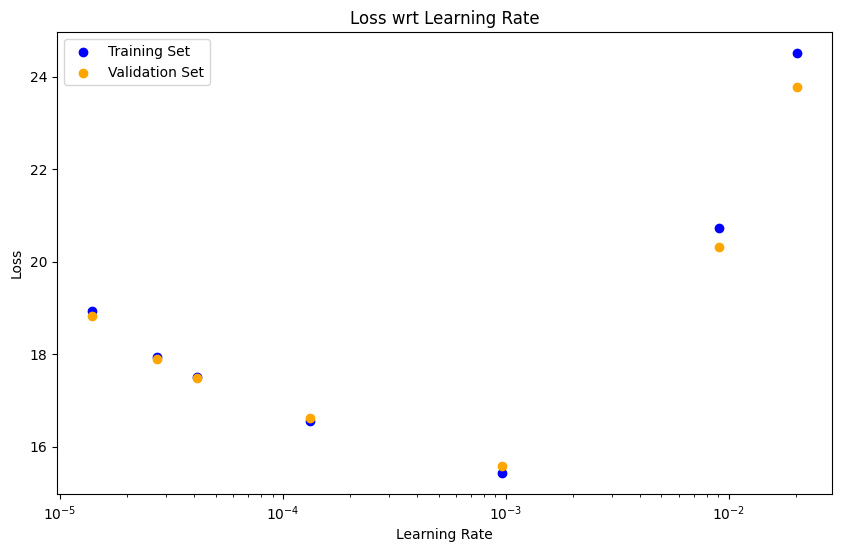

In [37]:


learning_rates = []
train_losses = []
val_losses = []

best_trials = tuner.oracle.get_best_trials(num_trials=10)

for trial in best_trials:
    
    if trial.trial_id != '01' :
        if trial.trial_id !='00' :
            if trial.trial_id !='09':
                print(trial.trial_id)
                trial_hps = trial.hyperparameters
                learning_rates.append(trial_hps.get('learning_rate'))
    
                train_loss = trial.metrics.get_history('loss')[-1]
                val_loss = trial.metrics.get_history('val_loss')[-1]
    
                train_losses.append(train_loss.value[0])
                val_losses.append(val_loss.value[0])
print (train_losses)
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.scatter(learning_rates, train_losses, color='blue', label='Training Set')
plt.scatter(learning_rates, val_losses, color='orange', label='Validation Set')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Loss wrt Learning Rate')
plt.legend()
plt.show()


In [41]:
# Charger l'état précédent du tuner
tuner.reload()

In [45]:


# Réinitialiser le tuner avec un nombre plus élevé de max_trials
tuner.max_trials = 20  # Augmentez le nombre d'essais supplémentaires

# Exécuter la recherche pour les essais supplémentaires
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Afficher les résultats des nouveaux essais
tuner.results_summary()

# Plot les résultats
plt.show()

Results summary
Results in my_dir\rnn_hyperparameter_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
learning_rate: 0.0009662794244316753
Score: 15.586491584777832

Trial 05 summary
Hyperparameters:
learning_rate: 0.00013289140039378445
Score: 16.613719940185547

Trial 02 summary
Hyperparameters:
learning_rate: 4.112496526150202e-05
Score: 17.480215072631836

Trial 04 summary
Hyperparameters:
learning_rate: 2.7180141980824003e-05
Score: 17.89426898956299

Trial 07 summary
Hyperparameters:
learning_rate: 1.3970040986169662e-05
Score: 18.82241153717041

Trial 03 summary
Hyperparameters:
learning_rate: 0.009018774637960088
Score: 20.316259384155273

Trial 08 summary
Hyperparameters:
learning_rate: 0.02023831614964907
Score: 23.784290313720703

Trial 09 summary
Hyperparameters:
learning_rate: 0.06384250503855154
Score: 25.214648246765137

Trial 01 summary
Hyperparameters:
learning_rate: 0.0009801313958028065
Traceback (most recen

In [39]:
# Réinitialiser le tuner avec un nombre plus élevé de max_trials
tuner.max_trials = 20  # Augmentez le nombre d'essais supplémentaires

# Exécuter la recherche pour les essais supplémentaires
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))

# Afficher les résultats des nouveaux essais
tuner.results_summary()

# Plot les résultats
plt.show()

Results summary
Results in my_dir\rnn_hyperparameter_tuning
Showing 10 best trials
Objective(name="val_loss", direction="min")

Trial 06 summary
Hyperparameters:
learning_rate: 0.0009662794244316753
Score: 15.586491584777832

Trial 05 summary
Hyperparameters:
learning_rate: 0.00013289140039378445
Score: 16.613719940185547

Trial 02 summary
Hyperparameters:
learning_rate: 4.112496526150202e-05
Score: 17.480215072631836

Trial 04 summary
Hyperparameters:
learning_rate: 2.7180141980824003e-05
Score: 17.89426898956299

Trial 07 summary
Hyperparameters:
learning_rate: 1.3970040986169662e-05
Score: 18.82241153717041

Trial 03 summary
Hyperparameters:
learning_rate: 0.009018774637960088
Score: 20.316259384155273

Trial 08 summary
Hyperparameters:
learning_rate: 0.02023831614964907
Score: 23.784290313720703

Trial 09 summary
Hyperparameters:
learning_rate: 0.06384250503855154
Score: 25.214648246765137

Trial 01 summary
Hyperparameters:
learning_rate: 0.0009801313958028065
Traceback (most recen

In [48]:
tuner.max_trials = 30  # Augmentez le nombre d'essais supplémentaires

In [50]:
def build_model(hp):
    model = ut.create_model('RNN', dims=250, n_Channels=n_Channels, n_Notes=n_Notes, n_Velocities=n_Velocities, time_range=time_range)
    
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=2e-2, sampling='log')
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    
    model.compile(optimizer=optimizer, loss=losses,loss_weights=loss_weights,metrics=metrics)
    model.summary()
    return model

In [49]:
# Lancer la recherche
tuner.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)
#history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))

Model: "RNN_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_16      │ (None, None, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_17      │ (None, None, 105) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_18      │ (None, None, 128) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_19      │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_4       │ (None, None, 246) │          0 │ input_layer_16[0… │
│ (Concatenate)       │                   │            │ input_layer_17[0… │
│                     │                   │            │ input_layer_18[0… │
│                     │                   │            │ input_layer_19[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_4        │ (None, None, 250) │    124,250 │ concatenate_4[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_16 (Dense)    │ (None, None, 12)  │      3,012 │ simple_rnn_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_17 (Dense)    │ (None, None, 105) │     26,355 │ simple_rnn_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_18 (Dense)    │ (None, None, 128) │     32,128 │ simple_rnn_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_19 (Dense)    │ (None, None, 1)   │        251 │ simple_rnn_4[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Channels (Softmax)  │ (None, None, 12)  │          0 │ dense_16[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Notes (Softmax)     │ (None, None, 105) │          0 │ dense_17[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Velocities          │ (None, None, 128) │          0 │ dense_18[0][0]    │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Times (Lambda)      │ (None, None, 1)   │          0 │ dense_19[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 185,996 (726.55 KB)

 Trainable params: 185,996 (726.55 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
# Lancer la recherche
# random search
tuner2 = RandomSearch(
    build_model,
    objective='val_loss',
    max_trials=20,
    executions_per_trial=2,
    directory='my_dir',
    project_name='rnn_hyperparameter_tuning'
)
tuner2.search(x_train, y_train, epochs=10, validation_data=(x_val, y_val))


best_hps = tuner2.get_best_hyperparameters(num_trials=1)[0]
model = tuner2.hypermodel.build(best_hps)
#history = model.fit(x_train, y_train, epochs=20, validation_data=(x_val, y_val))



Trial 20 Complete [00h 36m 40s]
val_loss: 19.216904640197754

Best val_loss So Far: 15.57093620300293
Total elapsed time: 14h 34m 26s


Model: "RNN_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, None, 12)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_5       │ (None, None, 105) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_6       │ (None, None, 128) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_7       │ (None, None, 1)   │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate_1       │ (None, None, 246) │          0 │ input_layer_4[0]… │
│ (Concatenate)       │                   │            │ input_layer_5[0]… │
│                     │                   │            │ input_layer_6[0]… │
│                     │                   │            │ input_layer_7[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ simple_rnn_1        │ (None, None, 250) │    124,250 │ concatenate_1[0]… │
│ (SimpleRNN)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, None, 12)  │      3,012 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, None, 105) │     26,355 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, None, 128) │     32,128 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, None, 1)   │        251 │ simple_rnn_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Channels (Softmax)  │ (None, None, 12)  │          0 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Notes (Softmax)     │ (None, None, 105) │          0 │ dense_5[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Velocities          │ (None, None, 128) │          0 │ dense_6[0][0]     │
│ (Softmax)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Times (Lambda)      │ (None, None, 1)   │          0 │ dense_7[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 185,996 (726.55 KB)

 Trainable params: 185,996 (726.55 KB)

 Non-trainable params: 0 (0.00 B)

In [55]:
print(len(best_trials))

10


17
12
06
16
10
15
05
13
02
04
11
18
07
19
03
08
14
[15.428727626800537, 16.55826473236084, 17.503936767578125, 17.937232971191406, 18.927096366882324, 20.72958755493164, 24.506179809570312, 15.428727626800537, 16.55826473236084, 17.503936767578125, 17.937232971191406, 18.927096366882324, 20.72958755493164, 24.506179809570312, 15.39655065536499, 15.396188735961914, 15.428727626800537, 15.935726165771484, 16.101821899414062, 16.440988540649414, 16.55826473236084, 17.211174964904785, 17.503936767578125, 17.937232971191406, 18.097496032714844, 18.27442169189453, 18.927096366882324, 19.772719383239746, 20.72958755493164, 24.506179809570312, 31.317232131958008]


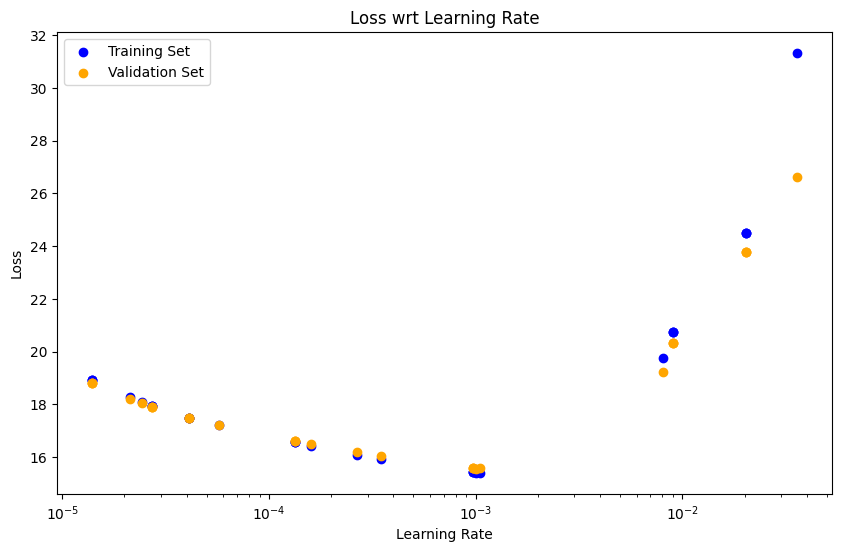

In [57]:
#learning_rates = []
#train_losses = []
#val_losses = []

best_trials = tuner2.oracle.get_best_trials(num_trials=20)

for trial in best_trials:
    
    if trial.trial_id != '01' :
        if trial.trial_id !='00' :
            if trial.trial_id !='09':
                print(trial.trial_id)
                trial_hps = trial.hyperparameters
                learning_rates.append(trial_hps.get('learning_rate'))
    
                train_loss = trial.metrics.get_history('loss')[-1]
                val_loss = trial.metrics.get_history('val_loss')[-1]
    
                train_losses.append(train_loss.value[0])
                val_losses.append(val_loss.value[0])
print (train_losses)
# Plot training and validation loss
plt.figure(figsize=(10, 6))
plt.scatter(learning_rates, train_losses, color='blue', label='Training Set')
plt.scatter(learning_rates, val_losses, color='orange', label='Validation Set')
plt.xlabel('Learning Rate')
plt.ylabel('Loss')
plt.xscale('log')
plt.title('Loss wrt Learning Rate')
plt.legend()
plt.show()